**Problem Description:**

The challenge is a binary image classification task aimed at detecting metastatic cancer in small image patches extracted from larger digital pathology scans. Specifically, the goal is to develop an algorithm that can accurately classify these patches as either containing metastatic cancer (positive label) or not (negative label). The presence of cancer is determined solely by the presence of tumor tissue within the center 32x32 pixel region of each patch. This task has significant clinical relevance, as it directly addresses the critical issue of cancer metastasis detection.

**Data Description:**

The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset. It consists of a large number of small, color pathology images. Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

-   **Size:** The dataset comprises thousands of image patches, split into training and testing sets.
-   **Dimension:** Each image patch has a fixed dimension of 96x96 pixels with 3 color channels (RGB).
-   **Structure:**
    -   The data (which is all stored in `data/`) is organized into two subdirectories: `train/` and `test/`.
    -   The `train` folder contains images for training the model, and the `test` folder contains images for which predictions are to be made.
    -   A `train_labels.csv` file provides the ground truth labels for the training images, mapping image IDs to binary labels (0 or 1).
    -   The labels are only determined by the center 32x32 pixel region of each image.
    -   The outer area of the 96x96 images are provided to support fully convolutional network architectures.
-   **Format:** Images are in standard image formats (tif).
-   **Class Imbalance:** It's important to note that the dataset exhibits class imbalance, with an unequal distribution of positive and negative samples.
-   **No Duplicates:** The Kaggle version of the PCam dataset has been processed to remove duplicate images, ensuring a cleaner training set.

In [18]:
# --- Standard Libraries ---
import os
import io
import warnings
warnings.filterwarnings('ignore')  # Cleaner output

# --- Data Manipulation & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Image Processing & Augmentation ---
import cv2
import albumentations as A  # Efficient augmentations
from albumentations.pytorch import ToTensorV2  # Optional for conversion

# --- TensorFlow & Deep Learning ---
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB3  # Backbones
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, 
                                    Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Legacy loader
from tensorflow.keras import backend as K

# --- Hyperparameter Tuning & Utilities ---
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [2]:
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
GPU Available: []


In [3]:
# Load labels and check dataset size
train_labels = pd.read_csv('data/train_labels.csv')
train_dir = 'data/train'
print(f"Total training samples: {len(train_labels)}")
print(f"Test directory file count: {len(os.listdir('data/test'))}")  # Verify test size

Total training samples: 220025
Test directory file count: 57458


In [4]:
# Display the first few rows of the labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


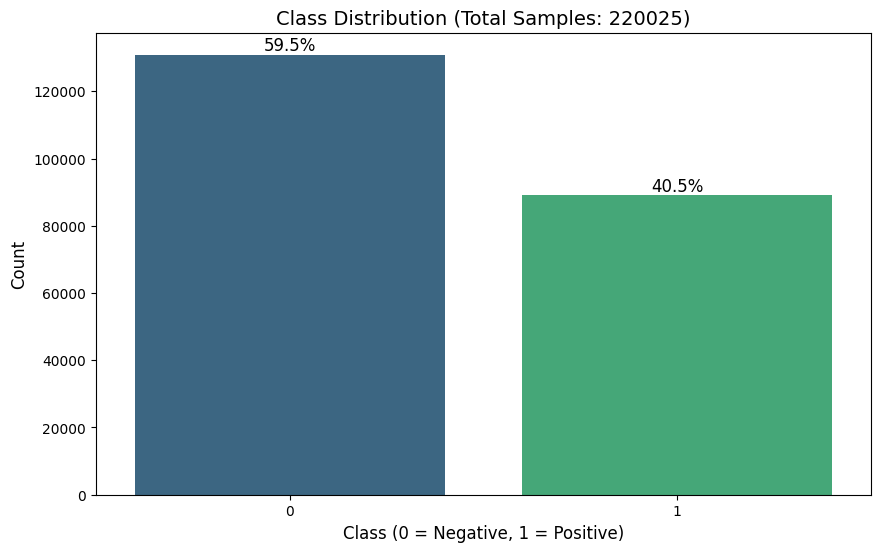

In [5]:
# Class distribution analysis
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=train_labels, palette='viridis')

# Add percentages to the plot
total = len(train_labels)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.title(f'Class Distribution (Total Samples: {total})', fontsize=14)
plt.xlabel('Class (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [6]:
# Numerical summary
class_counts = train_labels['label'].value_counts()
print(f"Class 0 (Negative): {class_counts[0]} samples ({class_counts[0]/total:.1%})")
print(f"Class 1 (Positive): {class_counts[1]} samples ({class_counts[1]/total:.1%})")

Class 0 (Negative): 130908 samples (59.5%)
Class 1 (Positive): 89117 samples (40.5%)


In [7]:
# Get positive & negative samples
num_samples = 5
positive_samples = train_labels[train_labels['label'] == 1].sample(n=num_samples, random_state=42)
negative_samples = train_labels[train_labels['label'] == 0].sample(n=num_samples, random_state=42)

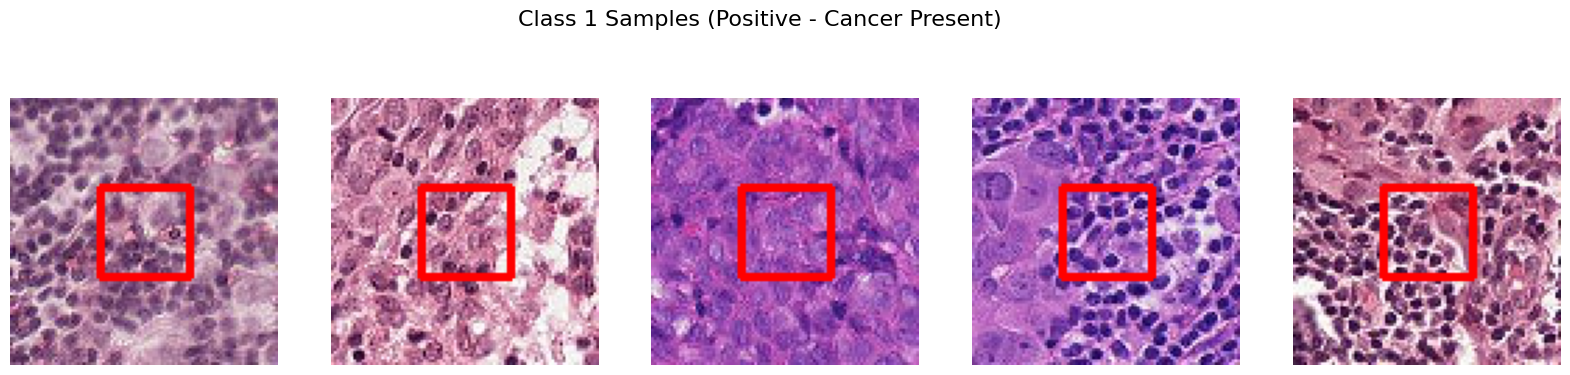

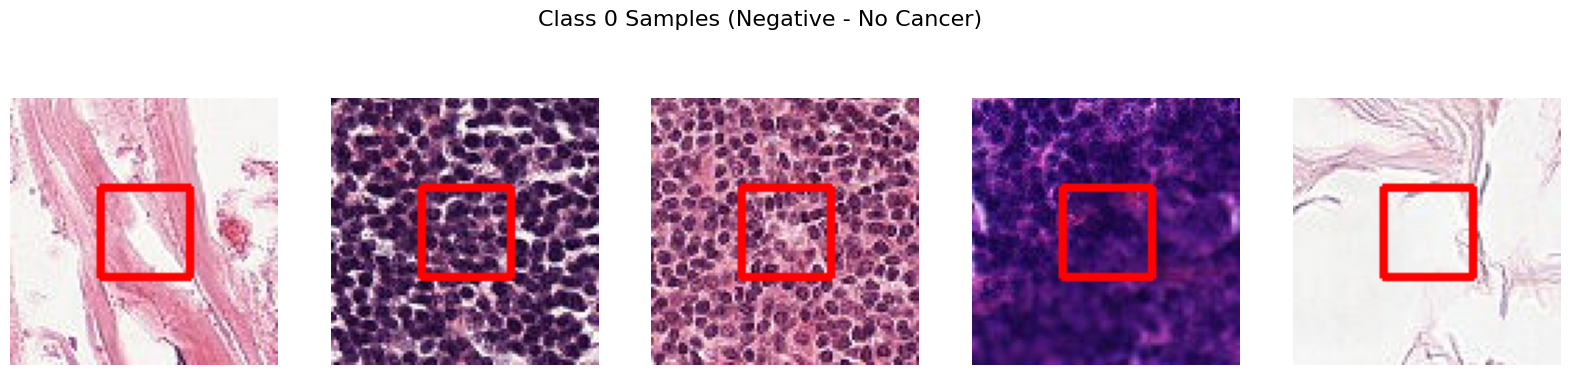

In [8]:
# Function to plot samples with center region highlighted
def plot_class_samples(df, class_label, num_samples=5, title_suffix=""):
    samples = df[df['label'] == class_label].sample(n=num_samples, random_state=42)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    fig.suptitle(f"Class {class_label} Samples {title_suffix}", y=1.05, fontsize=16)
    
    for ax, (idx, row) in zip(axes, samples.iterrows()):
        img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Highlight center region
        cv2.rectangle(img, (32, 32), (64, 64), (255, 0, 0), 2)  # Red rectangle
        
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Plot both classes with consistent formatting
plot_class_samples(train_labels, 1, title_suffix="(Positive - Cancer Present)")
plot_class_samples(train_labels, 0, title_suffix="(Negative - No Cancer)")

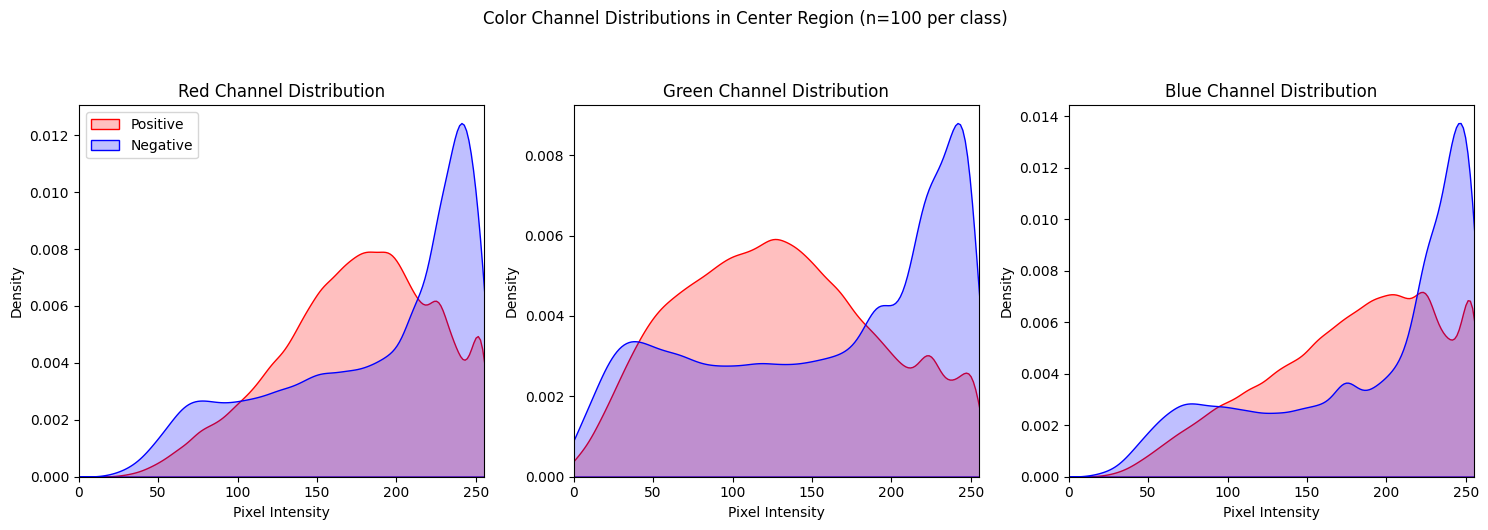

In [9]:
def compare_class_color_distributions(num_samples=100):
    plt.figure(figsize=(15, 5))
    
    # Sample images from both classes
    pos_samples = train_labels[train_labels['label'] == 1].sample(num_samples)
    neg_samples = train_labels[train_labels['label'] == 0].sample(num_samples)
    
    # Load and process images
    def get_center_pixels(samples):
        pixels = []
        for _, row in samples.iterrows():
            img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
            center_region = img[32:64, 32:64]  # Focus on diagnostic area
            pixels.append(center_region.reshape(-1, 3))
        return np.vstack(pixels)
    
    pos_pixels = get_center_pixels(pos_samples)
    neg_pixels = get_center_pixels(neg_samples)
    
    # Plot distributions
    channels = ['Red', 'Green', 'Blue']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(pos_pixels[:, i], color='r', label='Positive', fill=True)
        sns.kdeplot(neg_pixels[:, i], color='b', label='Negative', fill=True)
        plt.title(f'{channels[i]} Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.xlim(0, 255)
        if i == 0: plt.legend()
    
    plt.suptitle("Color Channel Distributions in Center Region (n=100 per class)", y=1.05)
    plt.tight_layout()
    plt.show()

compare_class_color_distributions()

In [10]:
# Calculate class weights for loss function

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels['label']), 
    y=train_labels['label'].values
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights (sklearn): {class_weights}")

Class Weights (sklearn): {0: 0.840380267057781, 1: 1.234472659537462}


In [11]:
def create_augmenter():
    return A.Compose([
        # Spatial transforms
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.05, 
            rotate_limit=15,
            p=0.5,
            border_mode=cv2.BORDER_CONSTANT
        ),
        
        # Color transforms
        A.RandomBrightnessContrast(p=0.3),
        A.CLAHE(p=0.3),
        A.HueSaturationValue(p=0.3),
        
        # Remove CropNonEmptyMaskIfExists
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()
    ])

In [12]:
# Split data into train/validation
train_df, val_df = train_test_split(
    train_labels, 
    test_size=0.2, 
    stratify=train_labels['label'],  # Preserve class balance
    random_state=42
)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 176020, Validation size: 44005


In [13]:
# Verify stratified split
def check_split_distribution(train_df, val_df):
    train_ratio = train_df['label'].mean()
    val_ratio = val_df['label'].mean()
    orig_ratio = train_labels['label'].mean()
    
    print(f"Original positive ratio: {orig_ratio:.4f}")
    print(f"Train positive ratio:    {train_ratio:.4f}")
    print(f"Val positive ratio:      {val_ratio:.4f}")
    
    assert np.isclose(train_ratio, orig_ratio, atol=0.005), "Train split not stratified!"
    assert np.isclose(val_ratio, orig_ratio, atol=0.005), "Val split not stratified!"

check_split_distribution(train_df, val_df)

Original positive ratio: 0.4050
Train positive ratio:    0.4050
Val positive ratio:      0.4050


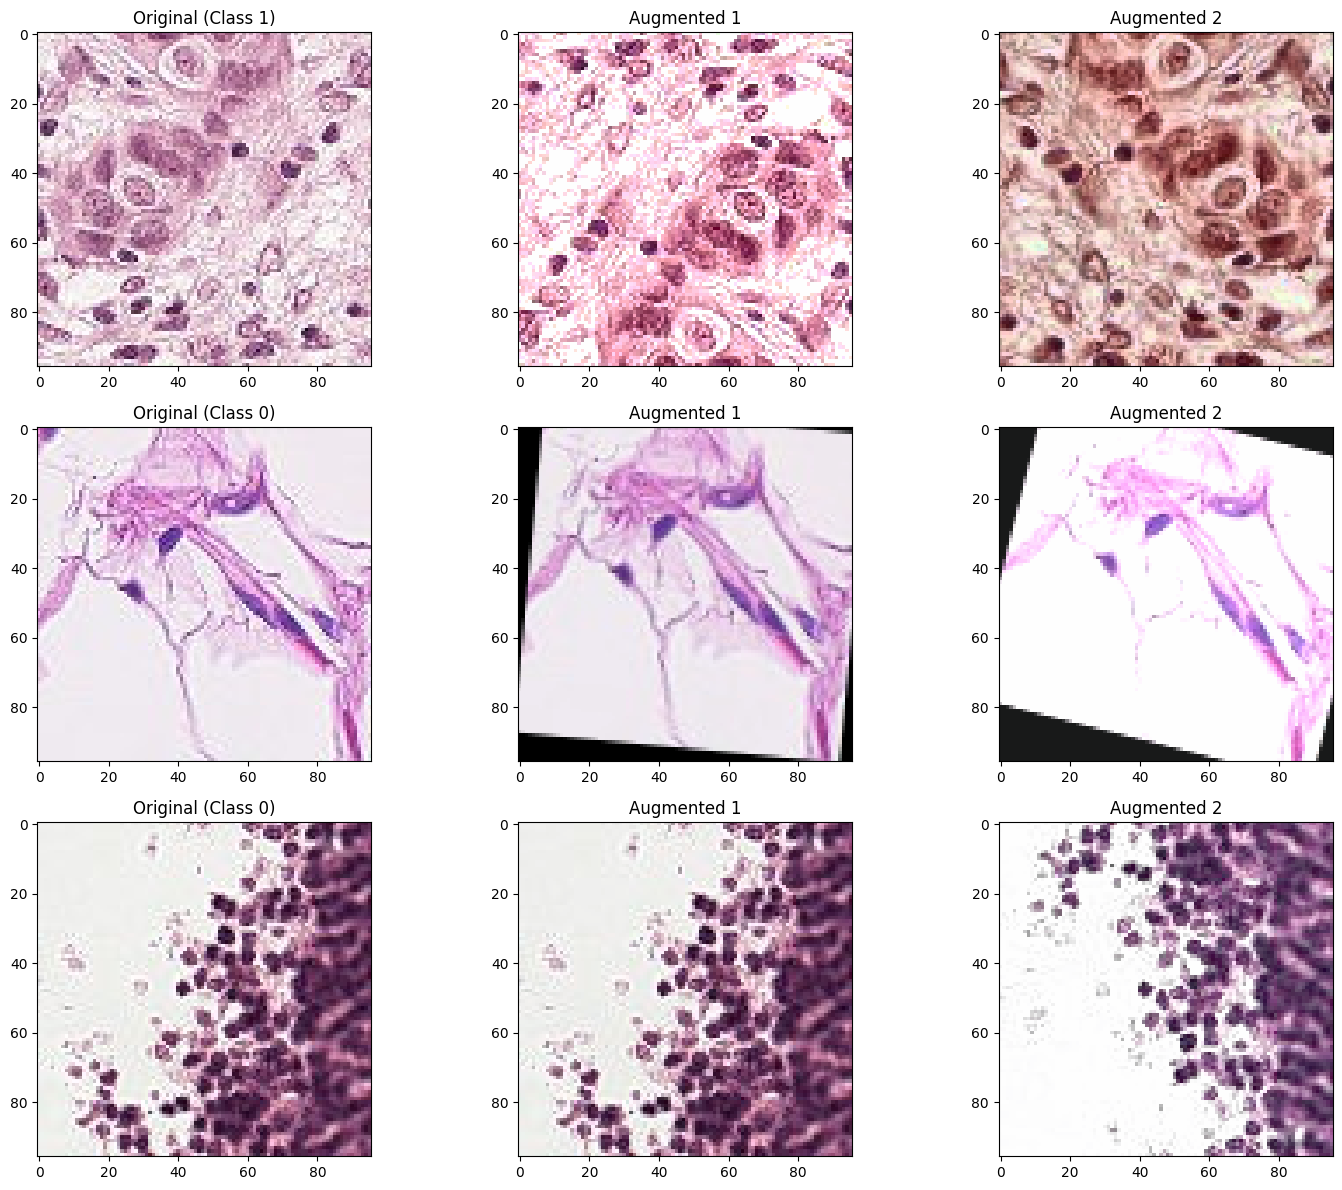

In [14]:
def visualize_augmentations(df, n=3):
    samples = df.sample(n)
    fig, axes = plt.subplots(n, 3, figsize=(15, 4*n))
    aug = create_augmenter()
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Original (normalized for visualization)
        axes[i,0].imshow(img/255.0)
        axes[i,0].set_title(f"Original (Class {row['label']})")
        
        # Apply augmentation twice
        for j in [1, 2]:
            augmented = aug(image=img)['image']
            # Convert tensor to numpy and denormalize
            augmented = augmented.numpy().transpose(1, 2, 0)
            augmented = augmented * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            augmented = np.clip(augmented, 0, 1)
            
            axes[i,j].imshow(augmented)
            axes[i,j].set_title(f"Augmented {j}")
            
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_labels)

### **Key Considerations for Architecture Design**

1.  **Focus on Center Region**:

    -   The critical diagnostic region is small (32x32 pixels), so architectures must prioritize local feature extraction over global context.

    -   Solutions: **Crop the center region** during preprocessing, use **attention mechanisms**, or design **weighted loss functions** to emphasize the center.

2.  **Class Imbalance**:

    -   Use **class weights**, **Focal Loss**, or **oversampling** to prevent bias toward the majority class.

3.  **Computational Efficiency**:

    -   96x96 images are smaller than typical ImageNet resolutions, but transfer learning with pretrained models (e.g., ResNet, EfficientNet) can still work with minor adaptations.

### **Architecture Comparison**

| **Model** | **Strengths** | **Weaknesses** | **Use Case** |
| --- | --- | --- | --- |
| **Simple CNN** | Fast, lightweight | Limited feature hierarchy | Baseline for quick testing |
| **ResNet-50 + Attention** | Strong pretrained features, dynamic focus | Computationally heavy | High-accuracy deployment |
| **EfficientNet-B3** | Efficient, scalable, good out-of-box performance | Requires tuning for medical images | Resource-constrained environments |

In [15]:
# ---------------------------
# 1. Simple CNN with Center Crop
# ---------------------------
def build_simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        layers.Rescaling(1./255),
        layers.Normalization(
            mean=[0.485, 0.456, 0.406], 
            variance=[0.229**2, 0.224**2, 0.225**2]
        ),
        layers.Cropping2D(cropping=((32, 32), (32, 32))),  # 96x96 → 32x32
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.BinaryCrossentropy(),
        metrics=[
            metrics.AUC(name='auc'),
            metrics.Precision(name='prec'),
            metrics.Recall(name='rec')
        ]
    )
    return model

# ---------------------------
# 2. ResNet-50 + Spatial Attention 
# ---------------------------
def spatial_attention_block(input_tensor):
    """Focus attention on center region with learnable weights"""
    # Channel aggregation
    avg_pool = layers.GlobalAveragePooling2D(keepdims=True)(input_tensor)
    max_pool = layers.GlobalMaxPooling2D(keepdims=True)(input_tensor)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    
    # Spatial attention with center bias
    attention = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(concat)
    
    # Add center region prior (32x32 at center)
    h, w = K.int_shape(input_tensor)[1], K.int_shape(input_tensor)[2]
    center_mask = np.zeros((1, h, w, 1))
    cy, cx = h//2, w//2
    center_mask[:, cy-16:cy+16, cx-16:cx+16, :] = 0.5  # Soft prior
    attention = layers.Add()([attention, tf.constant(center_mask, dtype=tf.float32)])
    
    return layers.Multiply()([input_tensor, attention])

def build_resnet_attention():
    inputs = layers.Input(shape=(96, 96, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Normalization(
        mean=[0.485, 0.456, 0.406], 
        variance=[0.229**2, 0.224**2, 0.225**2]
    )(x)
    
    base_model = ResNet50(
        include_top=False, 
        input_tensor=x,
        pooling=None
    )
    x = base_model.output
    
    x = spatial_attention_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    # Freezing strategy
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = True
        
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss=losses.BinaryFocalCrossentropy(gamma=2),
        metrics=[metrics.AUC(name='auc')]
    )
    return model

# ---------------------------
# 3. EfficientNet-B3 + Context Preservation
# ---------------------------
def build_efficientnet():
    inputs = layers.Input(shape=(96, 96, 3))
    
    # Context-aware preprocessing
    x = layers.RandomCrop(64, 64)(inputs)  # Random context around center
    x = layers.Resizing(224, 224)(x)       # Upscale for EfficientNet
    
    x = layers.Rescaling(1./255)(x)
    x = layers.Normalization(
        mean=[0.485, 0.456, 0.406], 
        variance=[0.229**2, 0.224**2, 0.225**2]
    )(x)
    
    base_model = EfficientNetB3(
        include_top=False, 
        weights='imagenet', 
        input_tensor=x
    )
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    # Partial fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
        
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss=losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=[metrics.AUC(name='auc')]
    )
    return model

### **Key Features Summary Table**

| Model | Input Size | Output Size | Parameters | Key Features |
| --- | --- | --- | --- | --- |
| **Simple CNN** | 96x96x3 | 32x32x3 | ~100K | Center cropping, lightweight |
| **ResNet-50+Attention** | 96x96x3 | 7x7x2048 | ~23M | Spatial attention with center prior, focal loss |
| **EfficientNet-B3** | 224x224x3 | 7x7x1536 | ~12M | Context preservation via random crops, label smoothing |

In [19]:
def create_dataset(df, augment=False):
    """Create optimized TF Dataset for TIFF images"""
    image_paths = df['id'].apply(lambda x: f"data/train/{x}.tif").tolist()
    labels = df['label'].values.astype(np.float32)
    
    # Create dataset from slices
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    def parse_image(path, label):
        """Read and decode TIFF image"""
        img_bytes = tf.io.read_file(path)
        try:
            # Use PIL to decode TIFF
            image = tf.py_function(
                lambda x: np.array(Image.open(io.BytesIO(x.numpy())).convert('RGB')),
                [img_bytes],
                tf.uint8
            )
            image.set_shape([96, 96, 3])  # Enforce expected shape
            return image, label
        except:
            print(f"Error reading {path}, skipping")
            return tf.zeros([96, 96, 3], dtype=tf.uint8), label
    
    def preprocess(image, label):
        """Standard preprocessing"""
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.per_image_standardization(image)
        return image, label
    
    # Map with proper argument handling
    dataset = dataset.map(
        lambda p, l: tf.py_function(parse_image, [p, l], [tf.uint8, tf.float32]),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        def augment_fn(image, label):
            """Augmentation pipeline"""
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            return image, label
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.batch(64).prefetch(2)

# Create datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.389126..0.99107295].


Image batch shape: (64, 96, 96, 3)
Label batch shape: (64,)


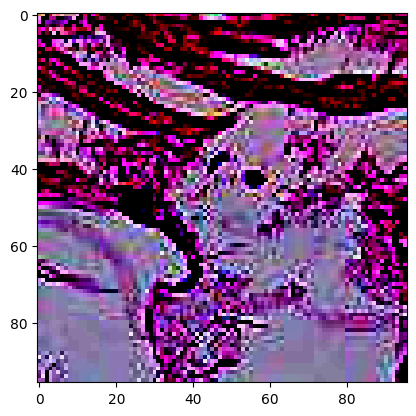

In [23]:
# Check first batch
sample_images, sample_labels = next(iter(train_ds))
print(f"Image batch shape: {sample_images.shape}")  # Should be (64, 96, 96, 3)
print(f"Label batch shape: {sample_labels.shape}")  # Should be (64,)

# Visualize sample
plt.imshow(sample_images[0].numpy().astype('float32'))
plt.show()

In [171]:
# Model Building with Tunable Parameters

def spatial_attention_block(input_tensor, hp):
    """Tunable attention mechanism with center bias"""
    # Channel aggregation
    avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
    concat = layers.Concatenate()([avg_pool, max_pool])
    
    # Tunable convolution
    filters = hp.Int('attn_filters', 8, 32, step=8)
    attention = layers.Conv2D(
        filters, 
        kernel_size=hp.Int('attn_kernel', 3, 7, step=2),
        padding='same',
        activation='sigmoid'
    )(concat)
    
    # Center region emphasis
    if hp.Boolean('center_bias'):
        _, h, w, _ = input_tensor.shape
        center_mask = np.zeros((1, h, w, 1))
        cy, cx = h//2, w//2
        center_mask[:, cy-16:cy+16, cx-16:cx+16, :] = 0.5
        attention = layers.Add()([attention, tf.constant(center_mask, dtype=tf.float32)])
    
    return layers.Multiply()([input_tensor, attention])

def build_model(hp):
    model_type = hp.Choice('model_type', ['simple_cnn', 'resnet_attn', 'efficientnet'])
    
    # Common input
    inputs = layers.Input(shape=(96, 96, 3))
    
    if model_type == 'simple_cnn':
        x = layers.Cropping2D(32)(inputs)  # Center 32x32
        
        # Tunable conv blocks
        for i in range(hp.Int('conv_blocks', 2, 4)):
            filters = hp.Int(f'filters_{i}', 32, 128, step=32)
            x = layers.Conv2D(filters, 3, activation='relu')(x)
            x = layers.MaxPooling2D(2)(x)
            if hp.Boolean(f'dropout_{i}'):
                x = layers.Dropout(hp.Float(f'dropout_rate_{i}', 0.2, 0.5))(x)
        
        x = layers.GlobalAveragePooling2D()(x)
        
    elif model_type == 'resnet_attn':
        # Base model
        base_model = ResNet50(
            include_top=False, 
            input_tensor=inputs,
            pooling=None
        )
        x = base_model.output
        
        # Tunable attention
        x = spatial_attention_block(x, hp)
        
        # Tunable head
        x = layers.GlobalAveragePooling2D()(x)
        for _ in range(hp.Int('dense_layers', 1, 3)):
            x = layers.Dense(hp.Int('dense_units', 128, 512, step=128), 
                           activation='relu')(x)
            x = layers.Dropout(hp.Float('dense_dropout', 0.3, 0.6))(x)
        
        # Freezing strategy
        trainable_layers = hp.Int('trainable_layers', 10, 50, step=10)
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
            
    elif model_type == 'efficientnet':
        # Input adaptation
        x = layers.Resizing(224, 224)(inputs)
        
        # Base model
        base_model = EfficientNetB3(
            include_top=False, 
            input_tensor=x,
            pooling=None
        )
        x = base_model.output
        
        # Optional attention
        if hp.Boolean('use_attention'):
            x = spatial_attention_block(x, hp)
            
        # Tunable pooling
        if hp.Boolean('global_avg_pool'):
            x = layers.GlobalAveragePooling2D()(x)
        else:
            x = layers.GlobalMaxPooling2D()(x)
        
        # Partial fine-tuning
        trainable_blocks = hp.Int('trainable_blocks', 3, 7)
        for layer in base_model.layers:
            layer.trainable = any([f'block{i}' in layer.name 
                                 for i in range(7-trainable_blocks, 7)])
    
    # Common output
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    
    # Compilation options
    lr = hp.Float('lr', 1e-5, 1e-3, sampling='log')
    optimizer = hp.Choice('optimizer', ['adam', 'adamw'])
    
    if optimizer == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    else:
        opt = optimizers.AdamW(learning_rate=lr, 
                             weight_decay=hp.Float('weight_decay', 1e-6, 1e-4))
    
    loss_fn = losses.BinaryFocalCrossentropy(
        gamma=hp.Float('gamma', 0.5, 3.0)
    ) if hp.Boolean('use_focal_loss') else losses.BinaryCrossentropy()
    
    model.compile(
        optimizer=opt,
        loss=loss_fn,
        metrics=[metrics.AUC(name='auc')]
    )
    
    return model

In [172]:
# Hyperparameter Tuning Setup

tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_epochs=30,
    factor=3,
    executions_per_trial=2,
    directory='tuning',
    project_name='cancer_detection_v3',
    overwrite=True
)

# Execute Tuning

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

# Retrieve Best Models

best_hps = tuner.get_best_hyperparameters(num_trials=3)

# Get top 3 models
top_models = [tuner.hypermodel.build(hp) for hp in best_hps]

# Compare architectures
results = []
for i, model in enumerate(top_models):
    print(f"\nTesting Model {i+1} ({model.name})")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        verbose=0
    )
    results.append({
        'architecture': model.name,
        'val_auc': max(history.history['val_auc']),
        'params': model.count_params(),
        'hp_config': best_hps[i].values
    })




Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
simple_cnn        |simple_cnn        |model_type
2                 |2                 |conv_blocks
128               |128               |filters_0
False             |False             |dropout_0
96                |96                |filters_1
True              |True              |dropout_1
2.7e-05           |2.7e-05           |lr
adamw             |adamw             |optimizer
True              |True              |use_focal_loss
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


In [21]:
# Analysis & Visualization

# Generate performance comparison DataFrame
results_df = pd.DataFrame(results).sort_values('val_auc', ascending=False)

# Plot results
plt.figure(figsize=(12, 6))
sns.barplot(x='architecture', y='val_auc', data=results_df)
plt.title('Top Model Architectures by Validation AUC')
plt.ylim(0.8, 1.0)
plt.show()

# Print best configurations
print("\nBest Hyperparameters:")
for config in results_df['hp_config'].head(3):
    print(json.dumps(config, indent=2))

NameError: name 'results' is not defined